In [248]:
import warnings
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score
from sklearn.metrics import silhouette_score
import plotly.express as px
from geopy.distance import geodesic
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
import random

 Accessing the API to retrieve necessary data for evaluation.


In [249]:
url ='https://data.gov.il/api/3/action/datastore_search?resource_id=21fde05f-62e3-401b-81cf-5c385862026d&limit=4000'
req= requests.get(url)
data_api = req.json()

In [250]:
data=pd.DataFrame(data_api['result']['records'])
data

,_id,Bank_Code,Bank_Name,Branch_Code,Atm_Num,ATM_Address,ATM_Address_Extra,City,Commission,ATM_Type,ATM_Location,Handicap_Access,X_Coordinate,Y_Coordinate
0,1,14,"בנק אוצר החייל בע""מ",355,3551,שד' מנחם בגין 7,"מרכז צימר, ככר הסיטי",אשדוד,לא,משיכת מזומן,על קיר הסניף,כן,31.788451,34.641896
1,2,14,"בנק אוצר החייל בע""מ",397,3976,שד' דואני 18,שד' דואני 18,יבנה,לא,מכשיר מידע/או מתן הוראות,במרחק של יותר מ- 500 מטר מהסניף,כן,31.873128,34.738887
2,3,14,"בנק אוצר החייל בע""מ",355,3552,שד' מנחם בגין 7,"מרכז צימר, ככר הסיטי",אשדוד,לא,משיכת מזומן,על קיר הסניף,כן,31.788451,34.641896
3,4,14,"בנק אוצר החייל בע""מ",377,3773,שד' התמרים 11,שדרות התמרים 11,אילת,לא,משיכת מזומן,בתוך הסניף,כן,29.555192,34.952591
4,5,14,"בנק אוצר החייל בע""מ",382,3821,יוספטל 92,קניון בת ים,בת ים,לא,משיכת מזומן,על קיר הסניף,כן,32.015182,34.756167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3364,3365,52,"בנק פועלי אגודת ישראל בע""מ",188,1882,יעקב לנדאו 4,,בני ברק,לא,משיכת מזומן,על קיר הסניף,כן,32.079522,34.833233
3365,3366,52,"בנק פועלי אגודת ישראל בע""מ",160,1601,אהרונוביץ 10,,בני ברק,לא,משיכת מזומן,על קיר הסניף,כן,32.091008,34.838876
3366,3367,26,"יובנק בע""מ",279,2791,הרצל 182,,רחובות,לא,משיכת מזומן,על קיר הסניף,כן,31.896860,34.811048
3367,3368,26,"יובנק בע""מ",288,2881,קרן היסוד 32,,ירושלים,לא,משיכת מזומן,על קיר הסניף,כן,31.772074,35.221880


In [251]:
#We noticed that some rows were written in the wrong columns. Since there were only a few of them, we decided to remove them as we have plenty of data.
data = data[(data['Handicap_Access'] == 'כן') | (data['Handicap_Access'] == 'לא')]


### Interactive map that shows the distribution of Handicap Accessibility 

In [252]:
fig = px.scatter_mapbox(data,lat="X_Coordinate",lon="Y_Coordinate",color="Handicap_Access",  color_discrete_map={'כן': 'green', 'לא': 'red'}, zoom=7,center={"lat":31.89, "lon": 35},title="ATM Accessibility Map",)

fig.update_layout(mapbox_style="open-street-map",width=1200,  height=800,legend_title=dict(text="Accessibility"))

fig.show()

## Preprocessing

In [253]:
X=data.drop(columns=['Handicap_Access'])
y=data['Handicap_Access']

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [255]:
#removing feature that are not helpful to our opinion
X_train = X_train.drop(columns=['ATM_Address_Extra', '_id', 'Bank_Name', 'Atm_Num'])
X_test = X_test.drop(columns=['ATM_Address_Extra', '_id', 'Bank_Name', 'Atm_Num'])

In [256]:
#removing blank/Nan values and taking care of features type 
X_train = X_train.drop(X_train[X_train['X_Coordinate'] == ''].index)
X_test = X_test.drop(X_test[X_test['X_Coordinate'] == ''].index)

X_train['X_Coordinate'] = X_train['X_Coordinate'].astype('float64')
X_train['Y_Coordinate'] = X_train['Y_Coordinate'].astype('float64')

X_test['X_Coordinate'] = X_test['X_Coordinate'].astype('float64')
X_test['Y_Coordinate'] = X_test['Y_Coordinate'].astype('float64')

In [257]:

X_train['ATM_Type'] = X_train['ATM_Type'].astype('category')
X_train['ATM_Location'] = X_train['ATM_Location'].astype('category')

X_test['ATM_Type'] = X_test['ATM_Type'].astype('category')
X_test['ATM_Location'] = X_test['ATM_Location'].astype('category')


y_train = y_train.astype('category')
y_test = y_test.astype('category')


In [258]:
#A few outliers intrupted our data duo to wrong typing so we decided to remove that as well

X_train = X_train[X_train['X_Coordinate'] < 90]
X_train = X_train[X_train['Y_Coordinate'] < 90]
y_train = y_train[X_train.index] 


X_test = X_test[X_test['X_Coordinate'] < 90]
X_test = X_test[X_test['Y_Coordinate'] < 90]
y_test = y_test[X_test.index] 


In [259]:
#Here we are mapping the yes and no handicap access feature
y_train = y_train.map({'כן': 1, 'לא': 0})
y_test = y_test.map({'כן': 1, 'לא': 0})


X_train['Commission'] = X_train['Commission'].map({'כן': 1, 'לא': 0})
X_test['Commission'] = X_test['Commission'].map({'כן': 1, 'לא': 0})


### ONE HOT Encoder

In [260]:
columns_to_encode = ['ATM_Address', 'City', 'ATM_Type', 'ATM_Location']


encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')


X_train_encoded = encoder.fit_transform(X_train[columns_to_encode])


X_test_encoded = encoder.transform(X_test[columns_to_encode])


X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(columns_to_encode))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(columns_to_encode))


X_train = X_train.drop(columns=columns_to_encode).reset_index(drop=True)
X_test = X_test.drop(columns=columns_to_encode).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

### Scaling

In [261]:
scaler = StandardScaler()


coordinates_train = X_train[['X_Coordinate', 'Y_Coordinate']]
coordinates_test = X_test[['X_Coordinate', 'Y_Coordinate']]


scaled_coordinates_train = scaler.fit_transform(coordinates_train)

scaled_coordinates_test = scaler.transform(coordinates_test)

X_train[['X_Coordinate', 'Y_Coordinate']] = scaled_coordinates_train
X_test[['X_Coordinate', 'Y_Coordinate']] = scaled_coordinates_test

#### Implementing the classification models and assessing their performance.

In [262]:
def eval(model, X_train, X_test, y_train, y_test):
   
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    #chat-gpt  only wrote if and else statements in this function we did
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1] 
    else:
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - np.min(y_prob)) / (np.max(y_prob) - np.min(y_prob))  

    
    cv = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
    

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print(f"Cross-validation accuracy={cv} Accuracy mean= {float(np.mean(cv))}")
    print(f"F1 score = {f1}")
    print(f"AUC = {auc}")
    print(f"Recall = {recall}")
    print(f"Precision = {precision}")

In [263]:
#We chose to predict whether there will be handicap accessibility based on the location, bank information, city, and ATM type. 
# Following this, we aim to cluster areas and recommend regions across the country where enforcement of handicap accessibility should be prioritized.

Logistic Regression 

In [264]:
eval(LogisticRegression(),X_train,X_test,y_train,y_test)

Cross-validation accuracy=[0.93668529 0.93482309 0.93482309 0.93482309 0.93656716] Accuracy mean= 0.9355443453125434
F1 score = 0.9772036474164134
AUC = 0.5682737169517884
Recall = 1.0
Precision = 0.9554234769687965


Random Forest 

In [265]:
eval(RandomForestClassifier(),X_train,X_test,y_train,y_test)

Cross-validation accuracy=[0.93482309 0.93482309 0.93296089 0.93296089 0.92537313] Accuracy mean= 0.9321882209066399
F1 score = 0.9701149425287356
AUC = 0.707153965785381
Recall = 0.9844479004665629
Precision = 0.9561933534743202


Support Vector Machine

In [266]:
eval(SVC(),X_train,X_test,y_train,y_test)

Cross-validation accuracy=[0.93482309 0.93482309 0.93482309 0.93482309 0.93656716] Accuracy mean= 0.9351719058339587
F1 score = 0.9772036474164134
AUC = 0.5057542768273717
Recall = 1.0
Precision = 0.9554234769687965


XGBoost

In [267]:
eval(XGBClassifier(),X_train,X_test,y_train,y_test) 

Cross-validation accuracy=[0.93296089 0.9273743  0.91806331 0.93296089 0.91977612] Accuracy mean= 0.9262271046999638
F1 score = 0.9698841698841699
AUC = 0.8072576464489374
Recall = 0.9766718506998445
Precision = 0.9631901840490797


K-Nearest Neighbors

In [268]:
eval(KNeighborsClassifier(),X_train,X_test,y_train,y_test)

Cross-validation accuracy=[0.93296089 0.9310987  0.9310987  0.9292365  0.92910448] Accuracy mean= 0.9306998526918481
F1 score = 0.9717341482047365
AUC = 0.7101088646967341
Recall = 0.9891135303265941
Precision = 0.954954954954955


In [269]:
xgb = XGBClassifier().fit(X_train,y_train)
y_pred = xgb.predict(X_test)

# Clusters

### Preprocessing

In [270]:
data = data.drop(data[data['X_Coordinate']==''].index)
data['X_Coordinate'] = data['X_Coordinate'].astype('float64')
data['Y_Coordinate'] = data['Y_Coordinate'].astype('float64')
data = data[data['X_Coordinate'] < 90]
data = data[data['Y_Coordinate'] < 90]

In [271]:
#removing feature that are not helpful to our opinion
data = data.drop(columns=['ATM_Address_Extra', '_id', 'Bank_Name', 'Atm_Num'])
coordinates = data[['X_Coordinate', 'Y_Coordinate']].values

In [272]:
#We came across this function online to calculate distances between points on a map 
def calculate_distance(row1, row2):
    point1 = (row1['X_Coordinate'], row1['Y_Coordinate'])
    point2 = (row2['X_Coordinate'], row2['Y_Coordinate'])
    return geodesic(point1, point2).meters  

## DBSCAN

In [273]:
data_dbscan = data.copy()
dbscan = DBSCAN(eps=0.068, min_samples=3)  
data_dbscan['Cluster'] = dbscan.fit_predict(coordinates)

In [274]:
fig = px.scatter_mapbox(data_dbscan,lat="X_Coordinate",lon="Y_Coordinate",color="Cluster", hover_data=["X_Coordinate", "Y_Coordinate", "Cluster", "Handicap_Access"],  color_continuous_scale='Viridis',  zoom=7,center={"lat":31.89, "lon": 35},title="ATM Clusters Map")

fig.update_layout(mapbox_style="open-street-map", width=1200,height=800,legend_title=dict(text="Clusters"))

fig.show()

## KMeans

In [275]:
data_kmeans = data.copy()
kmeans = KMeans(n_clusters=5)
data_kmeans['Cluster'] = kmeans.fit_predict(coordinates)

In [276]:
fig = px.scatter_mapbox(data_kmeans,lat="X_Coordinate",lon="Y_Coordinate",color="Cluster",  hover_data=["X_Coordinate", "Y_Coordinate", "Cluster", "Handicap_Access"],  color_continuous_scale='Viridis',  zoom=7,center={"lat":31.89, "lon": 35},title="ATM Clusters Map")

fig.update_layout(mapbox_style="open-street-map",width=1200,height=800,legend_title=dict(text="Clusters"))

fig.show()

## Gaussian Mixture Models

In [277]:
data_gmm = data.copy()
gmm = GaussianMixture(n_components=6, random_state=42)
data_gmm['Cluster'] = gmm.fit_predict(data_gmm[['X_Coordinate', 'Y_Coordinate']])

In [278]:

fig = px.scatter_mapbox(data_gmm,lat="X_Coordinate",lon="Y_Coordinate",color="Cluster",  hover_data=["X_Coordinate", "Y_Coordinate", "Cluster", "Handicap_Access"], color_continuous_scale='Viridis',  zoom=7,center={"lat":31.89, "lon": 35},title="ATM Clusters Map")

fig.update_layout(mapbox_style="open-street-map",width=1200,height=800,legend_title=dict(text="Clusters"))

fig.show()

In [279]:
# Assessing the performance of the clustering models

cluster_labels_dbscan = data_dbscan['Cluster']
cluster_labels_kmeans = data_kmeans['Cluster']
cluster_labels_gmm = data_gmm['Cluster']

silhouette_scores = {
    'DBSCAN': silhouette_score(data[['X_Coordinate', 'Y_Coordinate']], cluster_labels_dbscan),
    'K-Means': silhouette_score(data[['X_Coordinate', 'Y_Coordinate']], cluster_labels_kmeans),
    'GMM': silhouette_score(data[['X_Coordinate', 'Y_Coordinate']], cluster_labels_gmm)}


for method, score in silhouette_scores.items():
    print(f"{method} Silhouette Score: {score}")


DBSCAN Silhouette Score: 0.3872420122264845
K-Means Silhouette Score: 0.4898050498085075
GMM Silhouette Score: 0.5998970523868988


## We chose the GMM cluster as the best option for our task based on the silhouette score, our knowledge, and the visualizations.

In [280]:
# Mapping a map into regions
cluster_to_area = {
    0: 'צפון',
    1: 'דרום',
    2: 'אילת',
    3: 'חריגים',
    4: 'ירושלים',
    5: 'מרכז'
}

data_gmm['Area'] = data_gmm['Cluster'].map(cluster_to_area)

In [281]:
## This code evaluates the accessibility of each ATM on the map, checking both the accessibility of the ATM itself and its surrounding area. 
# It also verifies if the ATM provides additional services such as information retrieval and check deposit, not just cash withdrawal.
#we are very aware of the running times on this code and we couldn't find any better solution to what we wanted to acheive 


data_gmm['Need_access_Type'] = 'לא חריג'  


for cluster_num in data_gmm['Cluster'].unique():
    cluster_data_gmm = data_gmm[data_gmm['Cluster'] == cluster_num]
    
 
    for index, row in cluster_data_gmm.iterrows():

        
        if row['ATM_Location'] in ['בתוך הסניף', 'על קיר הסניף']:
            data_gmm.loc[index, 'Need_access'] = 'לא'  
            data_gmm.loc[index, 'Need_access_Type'] = 'לא חריג'
            continue

        if row['Handicap_Access'] == 'לא':
            found_accessible = False
            
            
            for idx, other_row in cluster_data_gmm.iterrows():
                if calculate_distance(row, other_row) <= 10 and other_row['Handicap_Access'] == 'כן':
                    found_accessible = True
                    break

            
            if not found_accessible:
                data_gmm.loc[index, 'Need_access'] = 'כן' 
                data_gmm.loc[index, 'Need_access_Type'] = 'אין כספומט נגיש בקרבה'
            else:
                data_gmm.loc[index, 'Need_access'] = 'לא'  
                data_gmm.loc[index, 'Need_access_Type'] = 'לא חריג'
        else:
            
            found_cash_withdrawal = False
            found_info_device = False
            
            
            for idx, other_row in cluster_data_gmm.iterrows():
                if calculate_distance(row, other_row) <= 50 and other_row['Handicap_Access'] == 'כן':
                    if other_row['ATM_Type'] == 'משיכת מזומן':
                        found_cash_withdrawal = True
                    elif other_row['ATM_Type'] == 'מכשיר מידע/או מתן הוראות':
                        found_info_device = True

            
            if (found_cash_withdrawal and found_info_device) or row['ATM_Location'] in ['בתוך הסניף', 'על קיר הסניף']:
                data_gmm.loc[index, 'Need_access'] = 'לא'  
                data.loc[index, 'Need_access_Type'] = 'לא חריג'
            else:
                data_gmm.loc[index, 'Need_access'] = 'כן'  
                data.loc[index, 'Need_access_Type'] = 'אין מגוון סוגים נגישים בקרבה'


In [282]:
data_gmm['Need_access_Type'].value_counts()

Need_access_Type
לא חריג                  3346
אין כספומט נגיש בקרבה      11
Name: count, dtype: int64

In [283]:
data_gmm['Need_access'].value_counts()

Need_access
לא    2921
כן     436
Name: count, dtype: int64

In [284]:

fig = px.scatter_mapbox(data_gmm,lat="X_Coordinate", lon="Y_Coordinate",  color="Need_access",  hover_data=["X_Coordinate", "Y_Coordinate", "Need_access_Type"],  color_discrete_map={"כן": "red", "לא": "green"},  zoom=7,center={"lat": 31.89, "lon": 35},  title="Accessibility for Disabled Map")

fig.update_layout(mapbox_style="open-street-map",width=1200,  height=800,  legend_title=dict(text="Accessability"))

fig.show()

In [285]:
data_gmm[data_gmm['Need_access'] == 'כן'].groupby('Cluster')['Need_access'].count()

Cluster
0     97
1     50
2      2
3      1
4     74
5    212
Name: Need_access, dtype: int64

In [286]:
city_Need_access = data_gmm[data_gmm['Cluster'] == 5].groupby('City')['Need_access'].count().sort_values(ascending=False)
city_Need_access

City
תל אביב -יפו    265
אשדוד            99
פתח תקווה        97
בני ברק          97
נתניה            93
               ... 
פלמחים            1
צור יצחק          1
קריית עקרון       1
קרני שומרון       1
שערי תקווה        1
Name: Need_access, Length: 66, dtype: int64

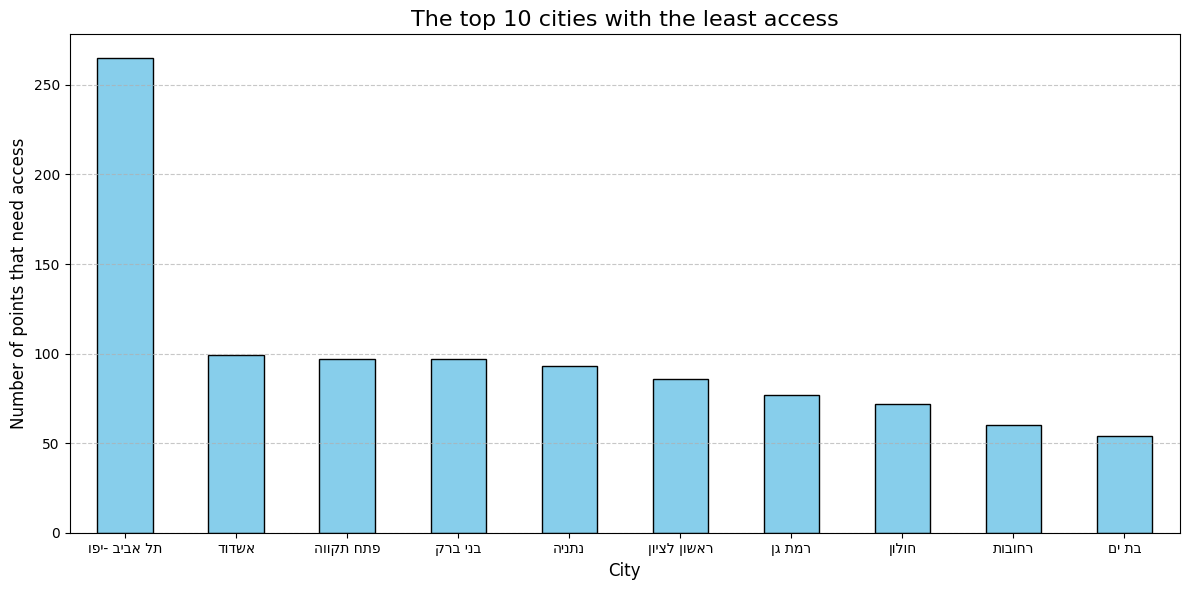

In [287]:
top_10_cities = city_Need_access.head(10)
plt.figure(figsize=(12, 6))
top_10_cities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("The top 10 cities with the least access", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Number of points that need access", fontsize=12)

plt.xticks(ticks=range(len(top_10_cities)), labels=[city[::-1] for city in top_10_cities.index], rotation=0, fontsize=10, rotation_mode='anchor')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### We can see that the city of Tel Aviv needs to address the issue of accessibility for individuals with disabilities.